# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

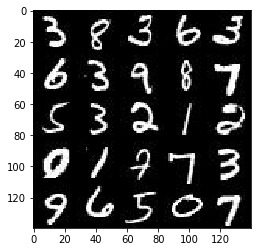

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

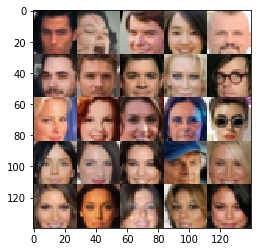

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # hidden layer 1
        h1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * h1, h1)
#         relu1 = tf.layers.dropout(relu1)
        
        # hidden layer 2
        h2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
#         relu2 = tf.layers.dropout(relu2)
 
        # hidden layer 3
        h3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
#         relu3 = tf.layers.dropout(relu3, 0.5)
        
        # flatten input
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1, activation=None)
#         logits = tf.layers.dropout(logits, 0.5)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # pre
        flat = tf.layers.dense(z, 7*7*1024)
        
        # hidden layer 1
        h1 = tf.reshape(flat, (-1, 7, 7, 1024))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
#         relu1 = tf.layers.dropout(relu1, 0.5)
        
        # hidden layer 2
        h2 = tf.layers.conv2d_transpose(relu1, 512, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
#         relu2 = tf.layers.dropout(relu2, 0.5)
        
        # output layer
        logits = tf.layers.conv2d_transpose(relu2, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    # Generator network here
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    # Disriminator network here
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_logits_real) * (1 - smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_real)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    output_dim = data_shape[3]
    
    # The inputs
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, output_dim, z_dim)
    
    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, output_dim)
    
    # Optimazation
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # rescale image
                batch_images = batch_images.reshape(batch_size, image_width, image_height, output_dim)
                batch_images = batch_images*2

                # Random Noise for Generator
                z_noise = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Optimization
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: z_noise, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: z_noise, input_real: batch_images, learn_rate: learning_rate})
                
                # Optimize Generator again 2nd
                _ = sess.run(g_train_opt, feed_dict={input_z: z_noise, input_real: batch_images, learn_rate: learning_rate})

                # Optimize Generator again 3rd
                _ = sess.run(g_train_opt, feed_dict={input_z: z_noise, input_real: batch_images, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # Determine losses and print
                    d_train_loss = d_loss.eval({input_real: batch_images, input_z: z_noise})
                    g_train_loss = g_loss.eval({input_z: z_noise})

                    print("Epoch {}/{} Batch# {}...".format(epoch_i+1, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(d_train_loss),
                          "Generator Loss: {:.4f}".format(g_train_loss))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, output_dim, data_image_mode)          
            
        print("END")

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 Batch# 10... Discriminator Loss: 8.6470... Generator Loss: 0.0113
Epoch 1/2 Batch# 20... Discriminator Loss: 2.1389... Generator Loss: 0.7731
Epoch 1/2 Batch# 30... Discriminator Loss: 2.4767... Generator Loss: 0.1807
Epoch 1/2 Batch# 40... Discriminator Loss: 1.7068... Generator Loss: 0.3639
Epoch 1/2 Batch# 50... Discriminator Loss: 1.9469... Generator Loss: 0.2932
Epoch 1/2 Batch# 60... Discriminator Loss: 1.8387... Generator Loss: 0.3659
Epoch 1/2 Batch# 70... Discriminator Loss: 1.8214... Generator Loss: 0.3574
Epoch 1/2 Batch# 80... Discriminator Loss: 1.7808... Generator Loss: 0.5545
Epoch 1/2 Batch# 90... Discriminator Loss: 1.9886... Generator Loss: 0.9734
Epoch 1/2 Batch# 100... Discriminator Loss: 1.8685... Generator Loss: 0.3403


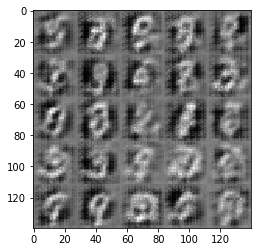

Epoch 1/2 Batch# 110... Discriminator Loss: 1.7740... Generator Loss: 0.3477
Epoch 1/2 Batch# 120... Discriminator Loss: 1.7825... Generator Loss: 0.3309
Epoch 1/2 Batch# 130... Discriminator Loss: 1.7936... Generator Loss: 0.3449
Epoch 1/2 Batch# 140... Discriminator Loss: 1.7964... Generator Loss: 0.3724
Epoch 1/2 Batch# 150... Discriminator Loss: 1.6408... Generator Loss: 0.4113
Epoch 1/2 Batch# 160... Discriminator Loss: 1.6264... Generator Loss: 0.4596
Epoch 1/2 Batch# 170... Discriminator Loss: 1.7601... Generator Loss: 0.4553
Epoch 1/2 Batch# 180... Discriminator Loss: 1.9459... Generator Loss: 0.2735
Epoch 1/2 Batch# 190... Discriminator Loss: 1.7284... Generator Loss: 0.4543
Epoch 1/2 Batch# 200... Discriminator Loss: 1.8199... Generator Loss: 0.3285


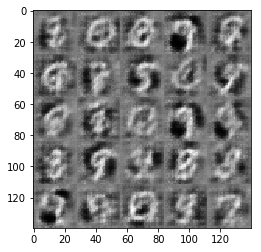

Epoch 1/2 Batch# 210... Discriminator Loss: 1.7914... Generator Loss: 0.3331
Epoch 1/2 Batch# 220... Discriminator Loss: 1.5351... Generator Loss: 0.6474
Epoch 1/2 Batch# 230... Discriminator Loss: 1.6857... Generator Loss: 1.1129
Epoch 1/2 Batch# 240... Discriminator Loss: 1.6415... Generator Loss: 1.0772
Epoch 1/2 Batch# 250... Discriminator Loss: 1.5031... Generator Loss: 0.5145
Epoch 1/2 Batch# 260... Discriminator Loss: 1.7051... Generator Loss: 0.3658
Epoch 1/2 Batch# 270... Discriminator Loss: 1.6930... Generator Loss: 0.4263
Epoch 1/2 Batch# 280... Discriminator Loss: 1.8859... Generator Loss: 0.2939
Epoch 1/2 Batch# 290... Discriminator Loss: 1.6003... Generator Loss: 0.7454
Epoch 1/2 Batch# 300... Discriminator Loss: 1.6889... Generator Loss: 1.1034


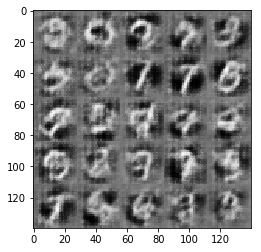

Epoch 1/2 Batch# 310... Discriminator Loss: 1.7727... Generator Loss: 1.0536
Epoch 1/2 Batch# 320... Discriminator Loss: 1.7140... Generator Loss: 1.1420
Epoch 1/2 Batch# 330... Discriminator Loss: 1.8664... Generator Loss: 0.2965
Epoch 1/2 Batch# 340... Discriminator Loss: 1.5045... Generator Loss: 0.6158
Epoch 1/2 Batch# 350... Discriminator Loss: 1.6073... Generator Loss: 0.4194
Epoch 1/2 Batch# 360... Discriminator Loss: 1.7026... Generator Loss: 0.3892
Epoch 1/2 Batch# 370... Discriminator Loss: 1.6179... Generator Loss: 0.7869
Epoch 1/2 Batch# 380... Discriminator Loss: 1.6567... Generator Loss: 1.1087
Epoch 1/2 Batch# 390... Discriminator Loss: 1.6365... Generator Loss: 0.9652
Epoch 1/2 Batch# 400... Discriminator Loss: 1.8924... Generator Loss: 1.4339


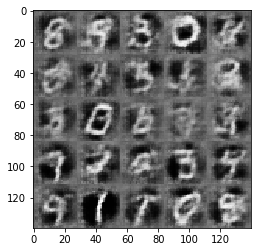

Epoch 1/2 Batch# 410... Discriminator Loss: 1.4446... Generator Loss: 0.7953
Epoch 1/2 Batch# 420... Discriminator Loss: 1.5546... Generator Loss: 0.8126
Epoch 1/2 Batch# 430... Discriminator Loss: 1.6635... Generator Loss: 1.2282
Epoch 1/2 Batch# 440... Discriminator Loss: 1.5924... Generator Loss: 0.4633
Epoch 1/2 Batch# 450... Discriminator Loss: 1.5704... Generator Loss: 0.4354
Epoch 1/2 Batch# 460... Discriminator Loss: 1.9188... Generator Loss: 0.2676
Epoch 1/2 Batch# 470... Discriminator Loss: 1.6197... Generator Loss: 0.4364
Epoch 1/2 Batch# 480... Discriminator Loss: 1.6651... Generator Loss: 0.3937
Epoch 1/2 Batch# 490... Discriminator Loss: 1.5481... Generator Loss: 0.8774
Epoch 1/2 Batch# 500... Discriminator Loss: 1.7186... Generator Loss: 1.1478


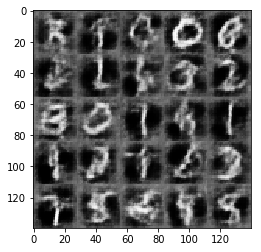

Epoch 1/2 Batch# 510... Discriminator Loss: 1.7182... Generator Loss: 1.1240
Epoch 1/2 Batch# 520... Discriminator Loss: 1.6336... Generator Loss: 1.0556
Epoch 1/2 Batch# 530... Discriminator Loss: 1.4756... Generator Loss: 0.7177
Epoch 1/2 Batch# 540... Discriminator Loss: 1.5628... Generator Loss: 0.8289
Epoch 1/2 Batch# 550... Discriminator Loss: 1.5135... Generator Loss: 0.8068
Epoch 1/2 Batch# 560... Discriminator Loss: 1.5701... Generator Loss: 0.7868
Epoch 1/2 Batch# 570... Discriminator Loss: 1.6198... Generator Loss: 1.2357
Epoch 1/2 Batch# 580... Discriminator Loss: 1.4709... Generator Loss: 1.0306
Epoch 1/2 Batch# 590... Discriminator Loss: 1.5437... Generator Loss: 0.9057
Epoch 1/2 Batch# 600... Discriminator Loss: 1.5744... Generator Loss: 1.0475


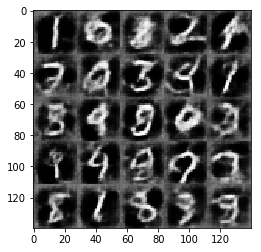

Epoch 1/2 Batch# 610... Discriminator Loss: 1.5181... Generator Loss: 0.8655
Epoch 1/2 Batch# 620... Discriminator Loss: 1.6181... Generator Loss: 0.6751
Epoch 1/2 Batch# 630... Discriminator Loss: 1.4938... Generator Loss: 0.8341
Epoch 1/2 Batch# 640... Discriminator Loss: 1.5085... Generator Loss: 0.9313
Epoch 1/2 Batch# 650... Discriminator Loss: 1.5723... Generator Loss: 0.6417
Epoch 1/2 Batch# 660... Discriminator Loss: 1.6047... Generator Loss: 0.4949
Epoch 1/2 Batch# 670... Discriminator Loss: 1.4554... Generator Loss: 0.6114
Epoch 1/2 Batch# 680... Discriminator Loss: 1.6567... Generator Loss: 0.4347
Epoch 1/2 Batch# 690... Discriminator Loss: 1.6463... Generator Loss: 0.4179
Epoch 1/2 Batch# 700... Discriminator Loss: 1.6182... Generator Loss: 1.0604


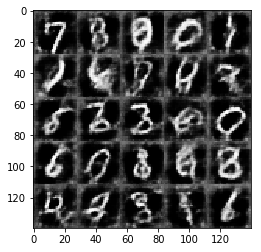

Epoch 1/2 Batch# 710... Discriminator Loss: 1.5554... Generator Loss: 0.5344
Epoch 1/2 Batch# 720... Discriminator Loss: 1.5649... Generator Loss: 0.5814
Epoch 1/2 Batch# 730... Discriminator Loss: 1.5641... Generator Loss: 0.7004
Epoch 1/2 Batch# 740... Discriminator Loss: 1.9814... Generator Loss: 0.2378
Epoch 1/2 Batch# 750... Discriminator Loss: 1.5374... Generator Loss: 0.4888
Epoch 1/2 Batch# 760... Discriminator Loss: 1.5454... Generator Loss: 0.6312
Epoch 1/2 Batch# 770... Discriminator Loss: 1.6713... Generator Loss: 0.4510
Epoch 1/2 Batch# 780... Discriminator Loss: 1.6385... Generator Loss: 0.4141
Epoch 1/2 Batch# 790... Discriminator Loss: 1.5397... Generator Loss: 0.7933
Epoch 1/2 Batch# 800... Discriminator Loss: 1.5829... Generator Loss: 1.0575


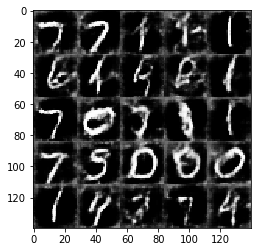

Epoch 1/2 Batch# 810... Discriminator Loss: 2.0691... Generator Loss: 0.2167
Epoch 1/2 Batch# 820... Discriminator Loss: 1.9805... Generator Loss: 0.2459
Epoch 1/2 Batch# 830... Discriminator Loss: 1.8949... Generator Loss: 0.3473
Epoch 1/2 Batch# 840... Discriminator Loss: 1.6280... Generator Loss: 0.4401
Epoch 1/2 Batch# 850... Discriminator Loss: 1.8052... Generator Loss: 0.3210
Epoch 1/2 Batch# 860... Discriminator Loss: 1.7407... Generator Loss: 0.3416
Epoch 1/2 Batch# 870... Discriminator Loss: 1.9655... Generator Loss: 0.2400
Epoch 1/2 Batch# 880... Discriminator Loss: 1.9669... Generator Loss: 0.2509
Epoch 1/2 Batch# 890... Discriminator Loss: 1.9616... Generator Loss: 0.2526
Epoch 1/2 Batch# 900... Discriminator Loss: 1.8748... Generator Loss: 0.2667


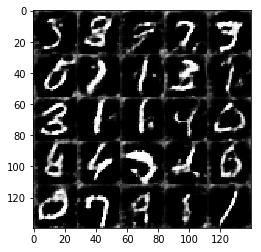

Epoch 1/2 Batch# 910... Discriminator Loss: 1.5152... Generator Loss: 0.4669
Epoch 1/2 Batch# 920... Discriminator Loss: 1.4968... Generator Loss: 0.5409
Epoch 1/2 Batch# 930... Discriminator Loss: 1.8984... Generator Loss: 0.2850
Epoch 2/2 Batch# 940... Discriminator Loss: 1.6254... Generator Loss: 0.4984
Epoch 2/2 Batch# 950... Discriminator Loss: 1.6420... Generator Loss: 0.3940
Epoch 2/2 Batch# 960... Discriminator Loss: 1.5798... Generator Loss: 0.4552
Epoch 2/2 Batch# 970... Discriminator Loss: 1.5717... Generator Loss: 0.4815
Epoch 2/2 Batch# 980... Discriminator Loss: 1.8162... Generator Loss: 0.3586
Epoch 2/2 Batch# 990... Discriminator Loss: 1.5097... Generator Loss: 0.9315
Epoch 2/2 Batch# 1000... Discriminator Loss: 1.6001... Generator Loss: 0.4210


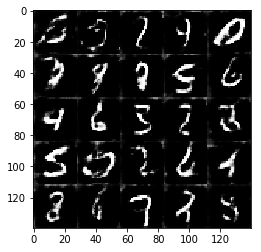

Epoch 2/2 Batch# 1010... Discriminator Loss: 1.9014... Generator Loss: 0.4343
Epoch 2/2 Batch# 1020... Discriminator Loss: 1.8158... Generator Loss: 0.3203
Epoch 2/2 Batch# 1030... Discriminator Loss: 1.6953... Generator Loss: 0.4398
Epoch 2/2 Batch# 1040... Discriminator Loss: 1.9097... Generator Loss: 0.2861
Epoch 2/2 Batch# 1050... Discriminator Loss: 1.8672... Generator Loss: 0.2978
Epoch 2/2 Batch# 1060... Discriminator Loss: 2.2062... Generator Loss: 0.2052
Epoch 2/2 Batch# 1070... Discriminator Loss: 1.6206... Generator Loss: 0.8540
Epoch 2/2 Batch# 1080... Discriminator Loss: 1.4412... Generator Loss: 0.6019
Epoch 2/2 Batch# 1090... Discriminator Loss: 1.6800... Generator Loss: 0.4878
Epoch 2/2 Batch# 1100... Discriminator Loss: 2.2421... Generator Loss: 0.1815


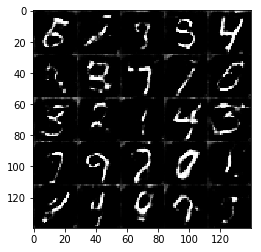

Epoch 2/2 Batch# 1110... Discriminator Loss: 1.5706... Generator Loss: 0.4383
Epoch 2/2 Batch# 1120... Discriminator Loss: 2.2317... Generator Loss: 0.2022
Epoch 2/2 Batch# 1130... Discriminator Loss: 1.5691... Generator Loss: 1.0574
Epoch 2/2 Batch# 1140... Discriminator Loss: 1.7957... Generator Loss: 0.3515
Epoch 2/2 Batch# 1150... Discriminator Loss: 1.7309... Generator Loss: 0.9953
Epoch 2/2 Batch# 1160... Discriminator Loss: 2.3758... Generator Loss: 0.1527
Epoch 2/2 Batch# 1170... Discriminator Loss: 1.9030... Generator Loss: 0.2698
Epoch 2/2 Batch# 1180... Discriminator Loss: 2.0628... Generator Loss: 0.3113
Epoch 2/2 Batch# 1190... Discriminator Loss: 1.6720... Generator Loss: 0.4438
Epoch 2/2 Batch# 1200... Discriminator Loss: 1.8559... Generator Loss: 0.3188


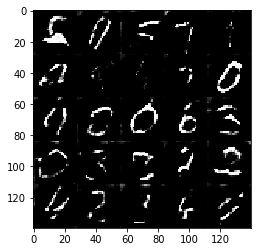

Epoch 2/2 Batch# 1210... Discriminator Loss: 1.7519... Generator Loss: 0.3945
Epoch 2/2 Batch# 1220... Discriminator Loss: 1.9166... Generator Loss: 0.2692
Epoch 2/2 Batch# 1230... Discriminator Loss: 2.1015... Generator Loss: 0.2224
Epoch 2/2 Batch# 1240... Discriminator Loss: 1.7392... Generator Loss: 0.4147
Epoch 2/2 Batch# 1250... Discriminator Loss: 2.4274... Generator Loss: 0.1781
Epoch 2/2 Batch# 1260... Discriminator Loss: 1.7452... Generator Loss: 0.3748
Epoch 2/2 Batch# 1270... Discriminator Loss: 1.5743... Generator Loss: 0.9980
Epoch 2/2 Batch# 1280... Discriminator Loss: 1.5535... Generator Loss: 0.6472
Epoch 2/2 Batch# 1290... Discriminator Loss: 1.7965... Generator Loss: 0.3226
Epoch 2/2 Batch# 1300... Discriminator Loss: 2.1141... Generator Loss: 0.2200


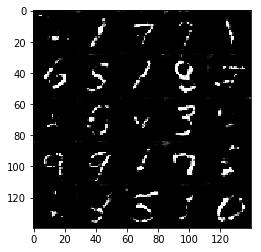

Epoch 2/2 Batch# 1310... Discriminator Loss: 2.0040... Generator Loss: 0.2779
Epoch 2/2 Batch# 1320... Discriminator Loss: 1.8090... Generator Loss: 0.3138
Epoch 2/2 Batch# 1330... Discriminator Loss: 2.8260... Generator Loss: 2.8270
Epoch 2/2 Batch# 1340... Discriminator Loss: 2.0886... Generator Loss: 0.2214
Epoch 2/2 Batch# 1350... Discriminator Loss: 1.5564... Generator Loss: 0.4542
Epoch 2/2 Batch# 1360... Discriminator Loss: 1.4396... Generator Loss: 0.5220
Epoch 2/2 Batch# 1370... Discriminator Loss: 1.7639... Generator Loss: 0.4171
Epoch 2/2 Batch# 1380... Discriminator Loss: 1.6545... Generator Loss: 0.4522
Epoch 2/2 Batch# 1390... Discriminator Loss: 1.6364... Generator Loss: 0.7984
Epoch 2/2 Batch# 1400... Discriminator Loss: 1.9100... Generator Loss: 0.4369


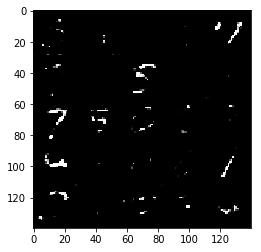

Epoch 2/2 Batch# 1410... Discriminator Loss: 2.0572... Generator Loss: 0.2432
Epoch 2/2 Batch# 1420... Discriminator Loss: 2.7919... Generator Loss: 0.1030
Epoch 2/2 Batch# 1430... Discriminator Loss: 1.5868... Generator Loss: 0.9263
Epoch 2/2 Batch# 1440... Discriminator Loss: 1.4827... Generator Loss: 1.1159
Epoch 2/2 Batch# 1450... Discriminator Loss: 1.7424... Generator Loss: 0.3231
Epoch 2/2 Batch# 1460... Discriminator Loss: 1.5470... Generator Loss: 0.7087
Epoch 2/2 Batch# 1470... Discriminator Loss: 2.3364... Generator Loss: 0.1805
Epoch 2/2 Batch# 1480... Discriminator Loss: 1.9211... Generator Loss: 0.2633
Epoch 2/2 Batch# 1490... Discriminator Loss: 1.7944... Generator Loss: 0.3327
Epoch 2/2 Batch# 1500... Discriminator Loss: 2.6694... Generator Loss: 0.1454


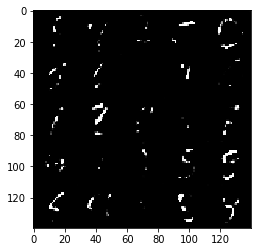

Epoch 2/2 Batch# 1510... Discriminator Loss: 1.5080... Generator Loss: 0.8375
Epoch 2/2 Batch# 1520... Discriminator Loss: 1.4125... Generator Loss: 0.7626
Epoch 2/2 Batch# 1530... Discriminator Loss: 1.7177... Generator Loss: 0.8569
Epoch 2/2 Batch# 1540... Discriminator Loss: 1.9874... Generator Loss: 0.2454
Epoch 2/2 Batch# 1550... Discriminator Loss: 2.1828... Generator Loss: 0.2015
Epoch 2/2 Batch# 1560... Discriminator Loss: 1.6308... Generator Loss: 1.3037
Epoch 2/2 Batch# 1570... Discriminator Loss: 1.9779... Generator Loss: 0.2722
Epoch 2/2 Batch# 1580... Discriminator Loss: 2.2435... Generator Loss: 0.1977
Epoch 2/2 Batch# 1590... Discriminator Loss: 1.6309... Generator Loss: 0.5060
Epoch 2/2 Batch# 1600... Discriminator Loss: 1.9069... Generator Loss: 0.3121


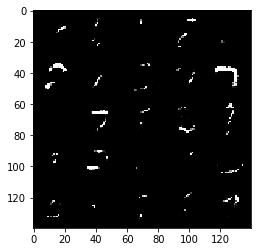

Epoch 2/2 Batch# 1610... Discriminator Loss: 1.8294... Generator Loss: 0.3306
Epoch 2/2 Batch# 1620... Discriminator Loss: 1.6247... Generator Loss: 0.4226
Epoch 2/2 Batch# 1630... Discriminator Loss: 1.9682... Generator Loss: 0.3499
Epoch 2/2 Batch# 1640... Discriminator Loss: 1.8012... Generator Loss: 0.3012
Epoch 2/2 Batch# 1650... Discriminator Loss: 1.5426... Generator Loss: 1.3221
Epoch 2/2 Batch# 1660... Discriminator Loss: 2.0613... Generator Loss: 0.2535
Epoch 2/2 Batch# 1670... Discriminator Loss: 1.9475... Generator Loss: 0.2874
Epoch 2/2 Batch# 1680... Discriminator Loss: 1.4667... Generator Loss: 0.7842
Epoch 2/2 Batch# 1690... Discriminator Loss: 1.6892... Generator Loss: 0.3720
Epoch 2/2 Batch# 1700... Discriminator Loss: 1.5477... Generator Loss: 0.5727


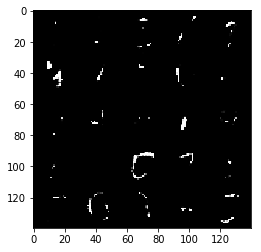

Epoch 2/2 Batch# 1710... Discriminator Loss: 1.5751... Generator Loss: 0.5116
Epoch 2/2 Batch# 1720... Discriminator Loss: 2.2385... Generator Loss: 0.2176
Epoch 2/2 Batch# 1730... Discriminator Loss: 2.0006... Generator Loss: 0.2870
Epoch 2/2 Batch# 1740... Discriminator Loss: 1.5166... Generator Loss: 1.3283
Epoch 2/2 Batch# 1750... Discriminator Loss: 1.4982... Generator Loss: 0.6240
Epoch 2/2 Batch# 1760... Discriminator Loss: 1.8363... Generator Loss: 0.3394
Epoch 2/2 Batch# 1770... Discriminator Loss: 1.6511... Generator Loss: 0.4218
Epoch 2/2 Batch# 1780... Discriminator Loss: 1.8435... Generator Loss: 0.3194
Epoch 2/2 Batch# 1790... Discriminator Loss: 1.4991... Generator Loss: 0.5397
Epoch 2/2 Batch# 1800... Discriminator Loss: 3.0037... Generator Loss: 0.1357


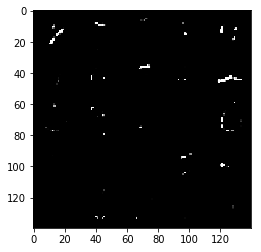

Epoch 2/2 Batch# 1810... Discriminator Loss: 1.5564... Generator Loss: 0.4417
Epoch 2/2 Batch# 1820... Discriminator Loss: 1.6697... Generator Loss: 0.4755
Epoch 2/2 Batch# 1830... Discriminator Loss: 2.2742... Generator Loss: 0.1979
Epoch 2/2 Batch# 1840... Discriminator Loss: 1.3728... Generator Loss: 0.5667
Epoch 2/2 Batch# 1850... Discriminator Loss: 2.2464... Generator Loss: 0.2514
Epoch 2/2 Batch# 1860... Discriminator Loss: 1.6354... Generator Loss: 0.4656
Epoch 2/2 Batch# 1870... Discriminator Loss: 1.6361... Generator Loss: 0.4373
END


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 Batch# 10... Discriminator Loss: 2.3178... Generator Loss: 3.9540
Epoch 1/1 Batch# 20... Discriminator Loss: 1.8016... Generator Loss: 0.5270
Epoch 1/1 Batch# 30... Discriminator Loss: 2.0783... Generator Loss: 0.3853
Epoch 1/1 Batch# 40... Discriminator Loss: 1.8822... Generator Loss: 0.5413
Epoch 1/1 Batch# 50... Discriminator Loss: 2.1857... Generator Loss: 0.2414
Epoch 1/1 Batch# 60... Discriminator Loss: 1.6812... Generator Loss: 1.0761
Epoch 1/1 Batch# 70... Discriminator Loss: 2.0271... Generator Loss: 1.4035
Epoch 1/1 Batch# 80... Discriminator Loss: 2.0774... Generator Loss: 0.8884
Epoch 1/1 Batch# 90... Discriminator Loss: 1.4502... Generator Loss: 1.2222
Epoch 1/1 Batch# 100... Discriminator Loss: 2.6641... Generator Loss: 0.1303


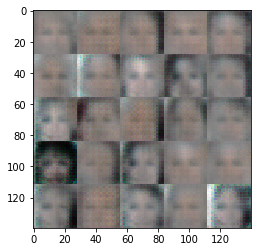

Epoch 1/1 Batch# 110... Discriminator Loss: 1.7690... Generator Loss: 0.5455
Epoch 1/1 Batch# 120... Discriminator Loss: 1.5057... Generator Loss: 0.8922
Epoch 1/1 Batch# 130... Discriminator Loss: 1.8811... Generator Loss: 0.4702
Epoch 1/1 Batch# 140... Discriminator Loss: 1.6688... Generator Loss: 0.5372
Epoch 1/1 Batch# 150... Discriminator Loss: 1.6973... Generator Loss: 0.7226
Epoch 1/1 Batch# 160... Discriminator Loss: 1.6844... Generator Loss: 0.6301
Epoch 1/1 Batch# 170... Discriminator Loss: 2.1398... Generator Loss: 0.4560
Epoch 1/1 Batch# 180... Discriminator Loss: 1.7023... Generator Loss: 0.5120
Epoch 1/1 Batch# 190... Discriminator Loss: 1.6739... Generator Loss: 0.6504
Epoch 1/1 Batch# 200... Discriminator Loss: 1.7260... Generator Loss: 0.5860


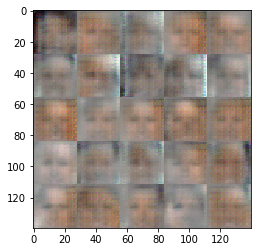

Epoch 1/1 Batch# 210... Discriminator Loss: 2.0060... Generator Loss: 0.4229
Epoch 1/1 Batch# 220... Discriminator Loss: 1.9079... Generator Loss: 0.6129
Epoch 1/1 Batch# 230... Discriminator Loss: 1.5721... Generator Loss: 0.6151
Epoch 1/1 Batch# 240... Discriminator Loss: 1.6606... Generator Loss: 0.6231
Epoch 1/1 Batch# 250... Discriminator Loss: 1.5061... Generator Loss: 0.7385
Epoch 1/1 Batch# 260... Discriminator Loss: 1.8221... Generator Loss: 0.5850
Epoch 1/1 Batch# 270... Discriminator Loss: 1.6129... Generator Loss: 0.9149
Epoch 1/1 Batch# 280... Discriminator Loss: 1.2807... Generator Loss: 0.9566
Epoch 1/1 Batch# 290... Discriminator Loss: 1.5218... Generator Loss: 1.2804
Epoch 1/1 Batch# 300... Discriminator Loss: 1.7841... Generator Loss: 1.4344


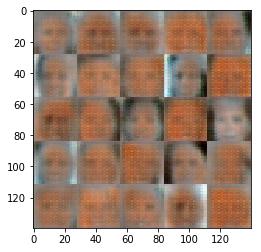

Epoch 1/1 Batch# 310... Discriminator Loss: 1.4419... Generator Loss: 0.9648
Epoch 1/1 Batch# 320... Discriminator Loss: 1.5380... Generator Loss: 1.1548
Epoch 1/1 Batch# 330... Discriminator Loss: 1.7539... Generator Loss: 0.4876
Epoch 1/1 Batch# 340... Discriminator Loss: 1.5763... Generator Loss: 0.9215
Epoch 1/1 Batch# 350... Discriminator Loss: 1.5005... Generator Loss: 0.6912
Epoch 1/1 Batch# 360... Discriminator Loss: 1.5041... Generator Loss: 1.1592
Epoch 1/1 Batch# 370... Discriminator Loss: 2.0225... Generator Loss: 0.2446
Epoch 1/1 Batch# 380... Discriminator Loss: 1.9689... Generator Loss: 0.2422
Epoch 1/1 Batch# 390... Discriminator Loss: 1.3614... Generator Loss: 0.9854
Epoch 1/1 Batch# 400... Discriminator Loss: 2.1291... Generator Loss: 0.3505


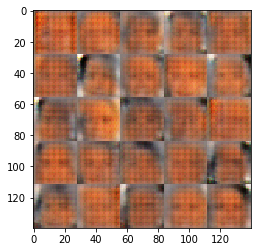

Epoch 1/1 Batch# 410... Discriminator Loss: 1.5488... Generator Loss: 0.7598
Epoch 1/1 Batch# 420... Discriminator Loss: 1.4155... Generator Loss: 0.7241
Epoch 1/1 Batch# 430... Discriminator Loss: 1.4809... Generator Loss: 0.5695
Epoch 1/1 Batch# 440... Discriminator Loss: 1.5580... Generator Loss: 0.5026
Epoch 1/1 Batch# 450... Discriminator Loss: 1.3051... Generator Loss: 1.1644
Epoch 1/1 Batch# 460... Discriminator Loss: 1.6210... Generator Loss: 0.6504
Epoch 1/1 Batch# 470... Discriminator Loss: 1.5576... Generator Loss: 0.6196
Epoch 1/1 Batch# 480... Discriminator Loss: 1.6760... Generator Loss: 0.6640
Epoch 1/1 Batch# 490... Discriminator Loss: 1.9714... Generator Loss: 0.4191
Epoch 1/1 Batch# 500... Discriminator Loss: 1.7389... Generator Loss: 0.6565


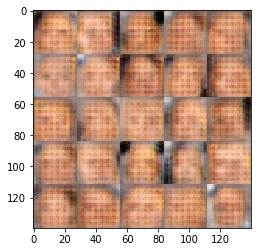

Epoch 1/1 Batch# 510... Discriminator Loss: 1.9558... Generator Loss: 0.5902
Epoch 1/1 Batch# 520... Discriminator Loss: 1.9357... Generator Loss: 0.4457
Epoch 1/1 Batch# 530... Discriminator Loss: 1.5110... Generator Loss: 0.6753
Epoch 1/1 Batch# 540... Discriminator Loss: 1.5041... Generator Loss: 0.6910
Epoch 1/1 Batch# 550... Discriminator Loss: 1.4247... Generator Loss: 0.7889
Epoch 1/1 Batch# 560... Discriminator Loss: 1.5404... Generator Loss: 0.7136
Epoch 1/1 Batch# 570... Discriminator Loss: 1.6626... Generator Loss: 0.5669
Epoch 1/1 Batch# 580... Discriminator Loss: 1.4794... Generator Loss: 0.7442
Epoch 1/1 Batch# 590... Discriminator Loss: 1.4623... Generator Loss: 0.7099
Epoch 1/1 Batch# 600... Discriminator Loss: 1.7490... Generator Loss: 0.4085


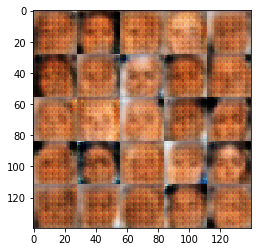

Epoch 1/1 Batch# 610... Discriminator Loss: 1.4515... Generator Loss: 0.5653
Epoch 1/1 Batch# 620... Discriminator Loss: 1.4647... Generator Loss: 0.5093
Epoch 1/1 Batch# 630... Discriminator Loss: 1.5615... Generator Loss: 1.2038
Epoch 1/1 Batch# 640... Discriminator Loss: 1.2160... Generator Loss: 1.0021


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.